In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.6 MB/s eta 0:00:00


In [3]:
#import libraries
import re
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nlpaug.augmenter.word as naw
from tqdm import tqdm

from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

#classifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# load resume.csv dataset using by pandas.
resume_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/resume_categorization/dataset/Resume/Resume.csv')

resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [5]:
resume_data.shape

(2484, 4)

In [6]:
resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [7]:
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [8]:
resume_data['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [9]:
# check how many resume are available in every category.
category = resume_data['Category'].value_counts().reset_index()
category

,Category,count
0,INFORMATION-TECHNOLOGY,120
1,BUSINESS-DEVELOPMENT,120
2,FINANCE,118
3,ADVOCATE,118
4,ACCOUNTANT,118
5,ENGINEERING,118
6,CHEF,118
7,AVIATION,117
8,FITNESS,117
9,SALES,116


<ipython-input-10-a59204c07e48>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category['Category'], y=category['count'], palette='rocket')


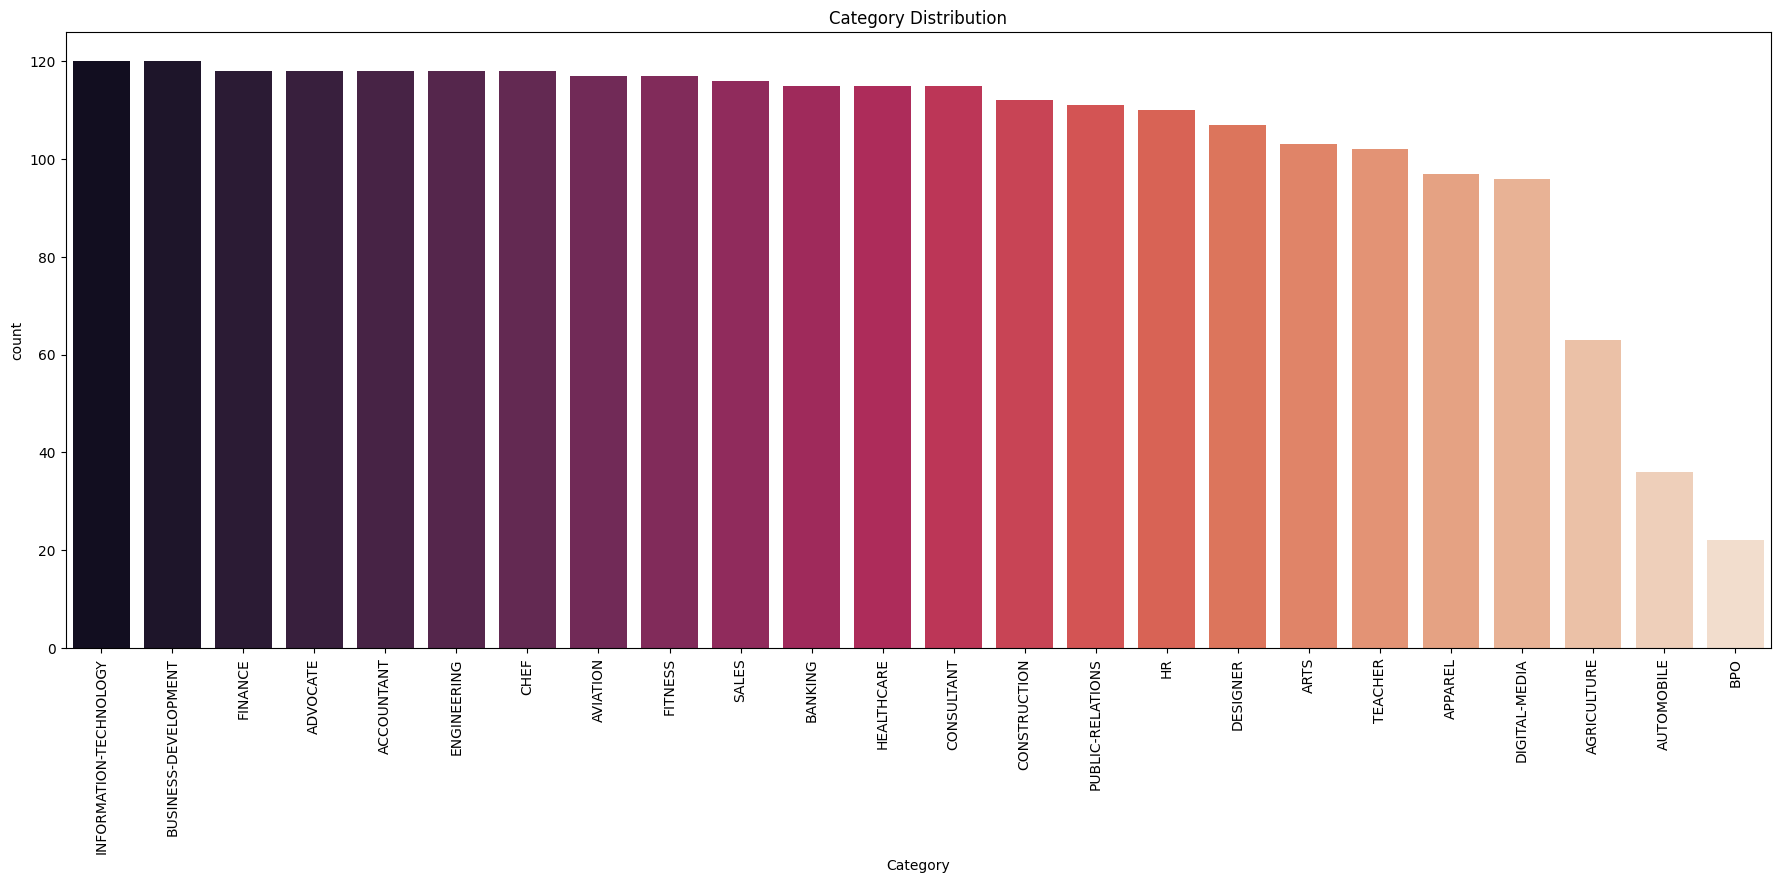

In [10]:
plt.figure(figsize=(22,8))
plt.xticks(rotation=90)
sns.barplot(x=category['Category'], y=category['count'], palette='rocket')
plt.title('Category Distribution')
plt.show()

## **Data Preprocessing**

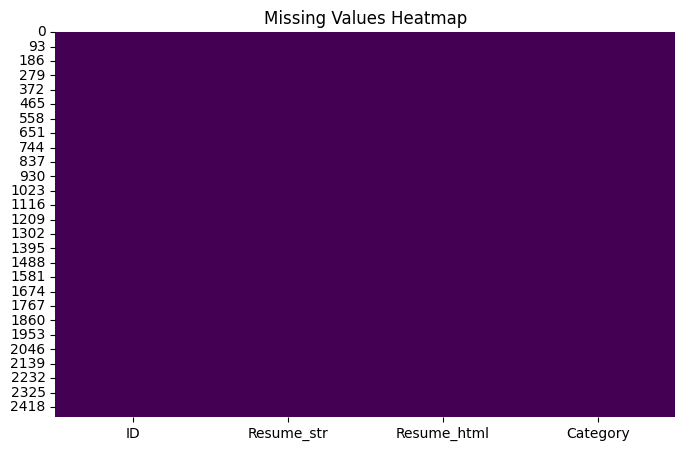

In [11]:
# Check for missing values
missing_values = resume_data.isnull().sum()

# Visualize missing values
plt.figure(figsize=(8, 5))
sns.heatmap(resume_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [12]:
resume_data.isnull().sum()

,0
ID,0
Resume_str,0
Resume_html,0
Category,0


In [13]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+\s*', ' ', text)
    # Remove RT and cc (common in social media)
    text = re.sub(r'\b(rt|cc)\b', ' ', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', ' ', text)
    # Remove punctuation using escape to ensure special characters are handled
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)
    # Remove any non-alphabetical characters (optional: if you want only English letters)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove continuous underscores (if necessary)
    text = re.sub(r'_+', ' ', text)
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [14]:
#now apply text cleaning function in my dataset
resume_data['Cleaned_Resume']=resume_data['Resume_str'].apply(lambda x:clean_text(x))

In [15]:
resume_data.head()

,ID,Resume_str,Resume_html,Category,Cleaned_Resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist us hr operations summary versati...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary over years experience in r...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicated driven and dyn...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlights hr skills hr depar...


In [16]:
# check any internal pdf are empty or not after cleaning procedure.

empty_rows = resume_data[resume_data['Cleaned_Resume'] == '']
print(empty_rows)

           ID             Resume_str  \
656  12632728                          

                                           Resume_html              Category  \
656  <div class="fontsize fontface vmargins hmargin...  BUSINESS-DEVELOPMENT   

    Cleaned_Resume  
656                 


In [17]:
# Drop 'Resume_str' and "Resume_html" columns
processed_data=resume_data.drop(['Resume_str', 'Resume_html'], axis=1)

# Drop the rows with empty cleaned text
processed_data = processed_data.drop(empty_rows.index)

In [18]:
processed_data.Cleaned_Resume[0]

'hr administrator marketing associate hr administrator summary dedicated customer service manager with years of experience in hospitality and customer service management respected builder and leader of customer focused teams strives to instill a shared enthusiastic commitment to customer service highlights focused on customer satisfaction team management marketing savvy conflict resolution techniques training and development skilled multi tasker client relations specialist accomplishments missouri dot supervisor training certification certified by ihg in customer loyalty and marketing by segment hilton worldwide general manager training certification accomplished trainer for cross server hospitality systems such as hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses and seminars in customer service sales strategies inventory control loss prevention safety time management leadership and performance assessment experience hr administrator marketing a

In [19]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = processed_data['Cleaned_Resume'].values
cleanedSentences = ""
for records in Sentences:
    cleanedSentences += records
    requiredWords = nltk.word_tokenize(records)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

# Remove most common words from each sentence
def remove_common_words(sentence):
    wordfreqdist = nltk.FreqDist(totalWords)
    mostcommon = wordfreqdist.most_common(5)
    words = nltk.word_tokenize(sentence)
    words = [word for word in words if word not in mostcommon]
    return ' '.join(words)

[('state', 16156), ('company', 15212), ('city', 15077), ('management', 12174), ('name', 11739), ('sales', 8275), ('customer', 7927), ('business', 7866), ('skills', 7727), ('new', 6409), ('service', 6223), ('team', 6072), ('development', 5731), ('training', 5637), ('experience', 5631), ('project', 5362), ('work', 4816), ('manager', 4531), ('information', 4502), ('marketing', 4489), ('financial', 4227), ('office', 4189), ('support', 4123), ('education', 4093), ('including', 4045), ('staff', 3950), ('professional', 3857), ('data', 3797), ('system', 3697), ('systems', 3559), ('university', 3477), ('managed', 3432), ('process', 3428), ('customers', 3418), ('design', 3383), ('quality', 3367), ('client', 3272), ('clients', 3244), ('developed', 3228), ('reports', 3089), ('analysis', 3052), ('operations', 3008), ('product', 2951), ('high', 2950), ('program', 2934), ('services', 2847), ('accounting', 2839), ('microsoft', 2830), ('current', 2787), ('accounts', 2778)]


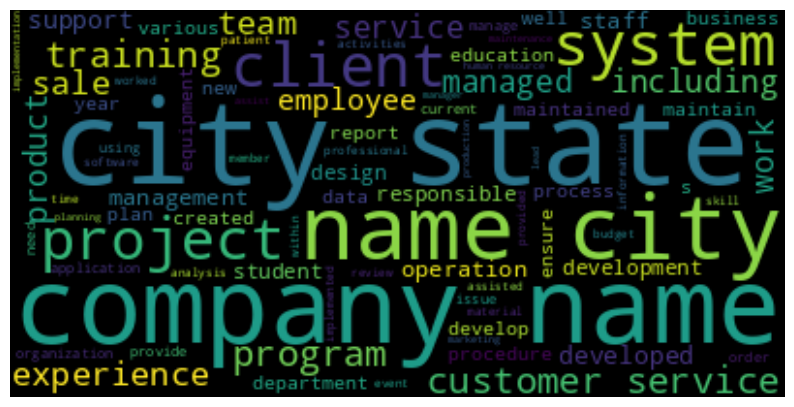

In [20]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
# Remove unnecessary words which are not important.
def remove_extra_word(text):

    extra_word=['company', 'name', 'city', 'state', 'university'] # extra words
    words = text.split()  # Split the text into words

    # Filter out the extra words
    filter_word = [word for word in words if word not in extra_word]

    filter_text = ' '.join(filter_word)

    return filter_text


# apply on resume_data['Cleaned_Resume']

processed_data['Cleaned_Resume']=processed_data['Cleaned_Resume'].apply(lambda x:remove_extra_word(x))

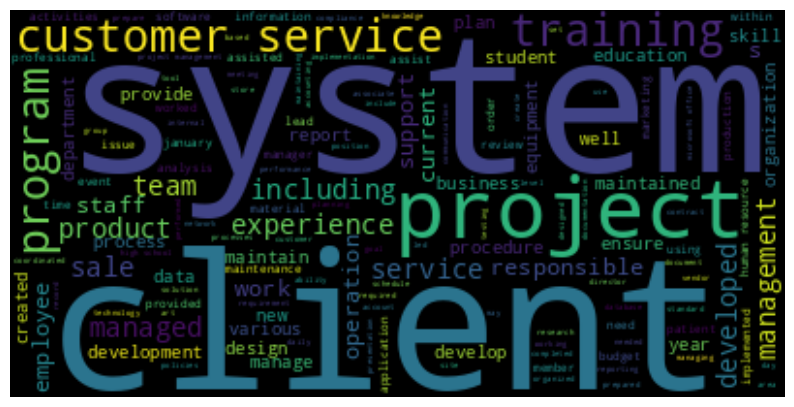

In [22]:
# Let's see what happended after remove unnecessary words
Sentences = processed_data['Cleaned_Resume'].values
cleanedSentences = ""
for records in Sentences:
    cleanedSentences += records
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Let's see wordcloud for each category

WORDCLOUD_COLOR_MAP = 'tab10_r'
def wordcloud(df):
    txt = ' '.join(txt for txt in df['Cleaned_Resume'])
    wordcloud = WordCloud(
        height=2000,
        width=4000,
        colormap=WORDCLOUD_COLOR_MAP
    ).generate(txt)

    return wordcloud

plt.figure(figsize=(32, 28))
# create list of all categories
categories = np.sort(processed_data['Category'].unique())
df_categories = [processed_data[processed_data['Category'] == category].loc[:, ['Cleaned_Resume', 'Category']] for category in categories]

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(9, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [24]:
# First, split the data into training and a combined validation + test set
train_data, val_test_data = train_test_split(
    processed_data,
    test_size=0.20,   # 30% of the data will be allocated to validation + test
    random_state=42,
    stratify=processed_data['Category']
)

# Now, split the combined val_test_data into separate validation and test sets
val_data, test_data = train_test_split(
    val_test_data,
    test_size=0.50,   # 50% of the val_test_data goes to test, 50% to validation
    random_state=42,
    stratify=val_test_data['Category']
)

# Summary of splits
print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")
print(f"Test data: {len(test_data)} samples")

Training data: 1986 samples
Validation data: 248 samples
Test data: 249 samples


In [25]:
train_data.reset_index(drop= True, inplace = True)
val_data.reset_index(drop= True, inplace = True)
test_data.reset_index(drop= True, inplace = True)

### **Data Augmentation**

In [27]:
# Initialize augmentation techniques
augmenter_synonym = naw.SynonymAug(aug_src='wordnet')
augmenter_antonym = naw.AntonymAug()
augmenter_swap = naw.RandomWordAug(action="swap")
augmenter_delete = naw.RandomWordAug(action="delete")

def random_augmentation(text):
    # Pick a random number between 0 and 3 for augmentation technique
    random_number = random.randint(0, 3)

    # Apply the corresponding augmentation based on the random number
    if random_number == 0:
        aug_text = augmenter_synonym.augment(text)
    elif random_number == 1:
        aug_text = augmenter_antonym.augment(text)
    elif random_number == 2:
        aug_text = augmenter_swap.augment(text)
    elif random_number == 3:
        aug_text = augmenter_delete.augment(text)

    return aug_text

# # Example usage
# text = "This is a sample text for augmentation."
# augmented_text = random_augmentation(text)
# print(augmented_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [28]:

labels = train_data.Category.unique()
resume = []
category = []
id = []

for label in tqdm(labels):
    # Find how many resumes are in the current category
    length = len(train_data[train_data['Category'] == label])

    # Determine how many new samples are needed to reach 90
    loop_range = 90 - length

    # Filter the dataframe to only include resumes from the current category
    df = train_data[train_data['Category'] == label]

    for _ in range(loop_range):
        # Shuffle the dataframe to get random samples
        df = df.sample(frac=1).reset_index(drop=True)

        # Get the resume text for augmentation
        text = df.iloc[0]['Cleaned_Resume']

        # Apply random augmentation to the resume text
        aug_text = random_augmentation(text)

        # Get ID
        ID = df.iloc[0]['ID']

        # Append the augmented text and label to the lists
        resume.append(aug_text)
        category.append(label)
        id.append(ID)

# You can now append these new resumes and categories back to the original dataset if needed
augmented_data = pd.DataFrame({'ID': id,'Cleaned_Resume': resume, 'Category': category})

  0%|          | 0/24 [00:00<?, ?it/s][nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
100%|██████████| 24/24 [00:10<00:00,  2.18it/s]


In [29]:
traincategory = train_data['Category'].value_counts().reset_index()
traincategory

,Category,count
0,INFORMATION-TECHNOLOGY,96
1,BUSINESS-DEVELOPMENT,95
2,CHEF,94
3,ENGINEERING,94
4,FINANCE,94
5,ACCOUNTANT,94
6,FITNESS,94
7,ADVOCATE,94
8,SALES,93
9,AVIATION,93


In [30]:
augcategory = augmented_data['Category'].value_counts().reset_index()
augcategory

,Category,count
0,BPO,72
1,AUTOMOBILE,61
2,AGRICULTURE,40
3,DIGITAL-MEDIA,13
4,APPAREL,12
5,ARTS,8
6,TEACHER,8
7,DESIGNER,4
8,HR,2
9,PUBLIC-RELATIONS,1


In [31]:
# Create a DataFrame from the augmented resumes and categories
aug_df = pd.DataFrame({"ID": id,"Cleaned_Resume": resume, "Category": category})

# Concatenate the original train data with the augmented data
aug_train_data = pd.concat([train_data, aug_df], ignore_index=True)

# Display the augmented dataset
print(aug_train_data.head())

         ID Category                                     Cleaned_Resume
0  20993320       HR  hr coordinator summary from my first job as a ...
1  33872500  BANKING  financial institutions examiner summary well r...
2  15145575      BPO  it support officer executive profile seeking a...
3  25101183  FINANCE  director of finance accomplishments senior fin...
4  11480899       HR  hr manager summary human resources manager wit...


In [32]:
aug_train_data.tail()

,ID,Category,Cleaned_Resume
2202,82140102,AUTOMOBILE,[adjuster experience adjuster to noncurrent ma...
2203,26341645,AUTOMOBILE,[sr business systems analyst career overview m...
2204,11257723,AUTOMOBILE,[general liability claim representative summar...
2205,24592627,AUTOMOBILE,[senior special investigator summary to work w...
2206,15100547,AUTOMOBILE,[student attorney criminal defense summary rec...


In [33]:
aug_train_data.Category.value_counts()

,count
Category,
INFORMATION-TECHNOLOGY,96
BUSINESS-DEVELOPMENT,95
CHEF,94
FINANCE,94
ACCOUNTANT,94
FITNESS,94
ENGINEERING,94
ADVOCATE,94
AVIATION,93


In [36]:
save_file_location = '/content/drive/MyDrive/Colab Notebooks/resume_categorization/dataset/processed_dataset/'
train_data.to_csv(save_file_location + 'train.csv')
aug_train_data.to_csv(save_file_location + 'train_aug.csv')
test_data.to_csv(save_file_location + 'test.csv')
val_data.to_csv(save_file_location + 'val.csv')

In [37]:
!pip freeze

absl-py==1.4.0
accelerate==0.33.0
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.14
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.3
astropy-iers-data==0.2024.8.27.10.28.29
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.15.0
bigquery-magics==0.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.19.0
cloudpickle==2.2.1
cmake==3.30.2
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5

In [38]:
!pip freeze >> requirements.txt